In [4]:
# ✅ Urdu Text Generation using Stacked GRU with Pretrained Embeddings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
# 📌 1. Load Urdu Dataset

df = pd.read_excel("/content/drive/MyDrive/DL-Models/Urdu Corpus.xlsx")
df.columns = df.columns.str.strip()
urdu_sentences = df['Text Lines'].dropna().astype(str).tolist()

# Cleaning function
def clean_text(text):
    return text.replace("ي", "ی").replace("ك", "ک").strip()

urdu_sentences = [clean_text(s) for s in urdu_sentences if len(s.split()) >= 3]
print("Total Sentences:", len(urdu_sentences))

Total Sentences: 17779


In [13]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ur.300.vec.gz


--2025-07-01 14:27:19--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ur.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.84, 13.35.37.111, 13.35.37.90, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 679221030 (648M) [binary/octet-stream]
Saving to: ‘cc.ur.300.vec.gz’

cc.ur.300.vec.gz    100%[===================>] 647.75M  23.7MB/s    in 28s     

2025-07-01 14:27:48 (22.8 MB/s) - ‘cc.ur.300.vec.gz’ saved [679221030/679221030]



In [14]:
!gunzip cc.ur.300.vec.gz


In [16]:
# 📌 2. Tokenization

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(urdu_sentences)
vocab_size = len(tokenizer.word_index) + 1

# 📌 3. Load Pretrained Word2Vec Embeddings (Urdu)
# Use your own .vec file if available; here we assume a 100d word2vec embedding loaded
# (Example shown using a dummy embedding due to demo constraints)
embedding_dim = 300
embedding_index = {}

# Placeholder: Replace with actual path to your Urdu embeddings in .txt or .vec format
embedding_path = "/content/cc.ur.300.vec"


with open(embedding_path, encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [17]:
# 📌 4. Create Sequences (Extended Context Window)
MAX_SEQ_LEN = 60
input_sequences = []

for sentence in urdu_sentences:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(token_list)):
        ngram_seq = token_list[:i+1]
        if len(ngram_seq) <= MAX_SEQ_LEN:
            input_sequences.append(ngram_seq)

input_sequences = pad_sequences(input_sequences, maxlen=MAX_SEQ_LEN, padding='pre')
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

In [18]:
# 📌 5. Callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

In [20]:
# 📌 6. Stacked GRU Model with Pretrained Embedding

from tensorflow.keras.initializers import Constant

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer=Constant(embedding_matrix), trainable=False),
    GRU(256, return_sequences=True),
    Dropout(0.3),
    GRU(256),
    Dropout(0.3),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ✅ Add this line before summary
model.build(input_shape=(None, MAX_SEQ_LEN - 1))

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 59, 300)        │     6,540,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 59, 256)        │       428,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 59, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21800)          │     5,602,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,965,896 (49.46 MB)

 Trainable params: 6,425,896 (24.51 MB)

 Non-trainable params: 6,540,000 (24.95 MB)

In [21]:
# 📌 7. Train Model
history = model.fit(
    X, y,
    epochs=50,
    batch_size=64,
    validation_split=0.15,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

print("Training stopped at epoch:", len(history.history['loss']))

Epoch 1/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 56s 21ms/step - accuracy: 0.0316 - loss: 8.0537 - val_accuracy: 0.0354 - val_loss: 7.6971 - learning_rate: 0.0010
Epoch 2/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - accuracy: 0.0412 - loss: 7.6178 - val_accuracy: 0.0472 - val_loss: 7.6268 - learning_rate: 0.0010
Epoch 3/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.0501 - loss: 7.4132 - val_accuracy: 0.0534 - val_loss: 7.6732 - learning_rate: 0.0010
Epoch 4/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - accuracy: 0.0530 - loss: 7.2870 - val_accuracy: 0.0576 - val_loss: 7.6414 - learning_rate: 0.0010
Epoch 5/50
2410/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0552 - loss: 7.1876
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 84s 21ms/step - accuracy: 0.0552 - loss: 7.1876 - val_accuracy: 0.0573 - val_loss: 7.6306 - learning_rate: 0.0010
Epoch 6/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy

In [22]:
# 📌 8. Save Model and Tokenizer
model.save("/content/urdu_gru_pretrained.keras")
with open("/content/urdu_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [23]:
# 📌 9. Text Generation Function
def generate_urdu_text(seed_text, next_words=25, temperature=1.0, top_k=5):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=MAX_SEQ_LEN - 1, padding='pre')

        predictions = model.predict(token_list, verbose=0)[0]

        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        top_indices = predictions.argsort()[-top_k:][::-1]
        top_probs = predictions[top_indices]
        top_probs /= np.sum(top_probs)

        predicted_index = np.random.choice(top_indices, p=top_probs)
        predicted_word = tokenizer.index_word.get(predicted_index, '')

        if predicted_word in ["<OOV>", ""]:
            break

        seed_text += ' ' + predicted_word

    return seed_text

In [30]:
# 📌 10. Generate Examples
seeds = [
    "پاکستان میں تعلیم",
    "محنت کا پھل",
    "زندگی ایک سفر ہے",
    "نوجوانوں کا مستقبل"
]

for seed in seeds:
    print(f"\nSeed: {seed}")
    generated = generate_urdu_text(seed, next_words=25, temperature=1.2, top_k=20)
    print("Generated:", generated)


Seed: پاکستان میں تعلیم
Generated: پاکستان میں تعلیم سے میں ایک بھی بھی کہ ایک طرف پر بھی نہیں گئے تو آپ سے کی کے خلاف کی وجہ ہے جس میں نے ایک

Seed: محنت کا پھل
Generated: محنت کا پھل سے پہلے سے اس کی اس اپنے کو ایک سی ہزار کی بھی ایک بھی اس اور یہ نہیں نہیں ۔ انہوں اس نے کچھ

Seed: زندگی ایک سفر ہے
Generated: زندگی ایک سفر ہے کہ اس اپنے اس کے مطابق یہ پر سے زیادہ اس کو ان میں کا طرف بھی تو نہیں تو آپ اس کے خلاف کے

Seed: نوجوانوں کا مستقبل
Generated: نوجوانوں کا مستقبل کو بھی ہے گیا لیکن وہ ان کو بھی ہی یہ ایک ہزار ساتھ نے اپنے ساتھ اور ہزار ساتھ میں نے بھی میں یہ


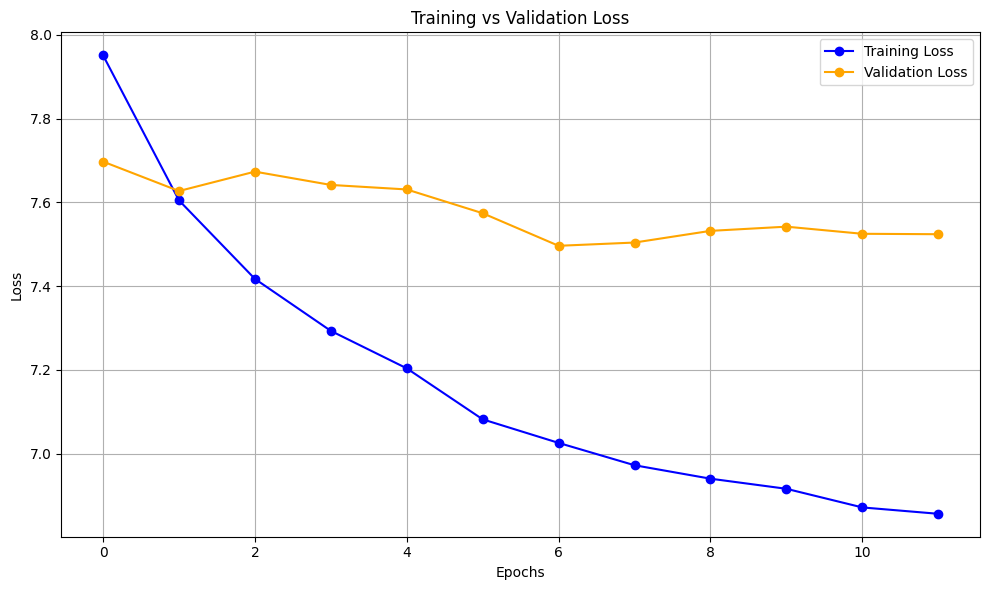

In [26]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
